In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import emoji
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [21]:
data = 'sample.csv'

In [22]:
data = pd.read_csv(data, lineterminator='\n')
tweet = data[['text', 'country_code']].copy()

# Data cleaning

In [23]:
peaceful = ['CA', 'FI', 'GB', 'NO', 'IE', 'AU', 'SG', 'FR']
tweet['peacefulness'] = tweet.country_code.apply(lambda x: 1 if (x in peaceful) else 0)
tweet['new_text'] = tweet.text.apply(lambda x: emoji.demojize(x).replace(":", " ").replace("_", " "))

In [24]:
# with regular expressions
# https://medium.com/mlearning-ai/elon-musks-twitter-sentiment-analysis-with-transformers-hugging-face-roberta-49b9e61b1433
# https://www.kaggle.com/code/ludovicocuoghi/twitter-sentiment-analysis-with-bert-roberta/notebook
# https://stackoverflow.com/questions/44027943/python-regex-to-remove-emails-from-string

def clean_re(tweet):
    # remove username
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    # remove links
    tweet = re.sub(r'http\S+', '', tweet) 
    tweet = re.sub(r'bit.ly/\S+', '', tweet) 
    tweet = tweet.strip('[link]') 
    # remove email address
    tweet = re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*', "", tweet)
    # remove special characters
    tweet = re.sub('([_]+)', "", tweet)
    tweet = tweet.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    # remove links
    tweet = re.sub(r"(?:\@|https?\://)\S+", "", tweet)
    # remove non-ascii characters
    tweet = re.sub(r'[^\x00-\x7f]',r'', tweet)
    # remove multiple spaces
    tweet = re.sub("\s\s+" , " ", tweet)
    # remove punctuation
    tweet = re.sub(r'[^\w\s]', '', tweet)
    return tweet

In [25]:
tweet['new_text'] = tweet.new_text.apply(func = clean_re)

from nltk.stem import PorterStemmer, WordNetLemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
tweet['stemmed'] = tweet['new_text'].apply(lambda x: stemmer.stem(x))
tweet['stemmed'] = tweet['stemmed'].apply(lambda x: lemmatizer.lemmatize(x))
tweet['stemmed'] = tweet['stemmed'].str.replace('\d+', '')

/Users/ruziheng/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [26]:
# https://www.kaggle.com/code/sharat111/multilabelclassificationofblogauthor-completesoln
words = set(nltk.corpus.words.words())

tweet['stemmed'] = tweet['stemmed'].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))

In [27]:
high = tweet[tweet['peacefulness'] == 1]
low = tweet[tweet['peacefulness'] == 0]

# Corpus based on common words

In [28]:
# find corpus of high peace countries
high_corpus = [' '.join(high['stemmed'])]
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english')
high_vectors = tfidf_vectorizer.fit_transform(high_corpus)
highfeature_names = tfidf_vectorizer.get_feature_names()

high_peace = np.asarray(highfeature_names)

In [29]:
# find corpus of low peace countries
low_corpus = [' '.join(low['stemmed'])]
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english')
low_vectors = tfidf_vectorizer.fit_transform(low_corpus)
lowfeature_names = tfidf_vectorizer.get_feature_names()

low_peace = np.asarray(lowfeature_names)

In [30]:
# find words that exist in both high peace and low peace countries and only look into these words
common_peace = np.intersect1d(high_peace, low_peace)

In [31]:
len(common_peace)

12365

# Logistic Regression

In [33]:
tweet_all = tweet[['stemmed', 'peacefulness']].copy()
x = tweet_all['stemmed'].to_frame()
y = tweet_all['peacefulness']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30)

In [34]:
# https://www.kaggle.com/code/onadegibert/sentiment-analysis-with-tfidf-and-random-forest/notebook
def vectorize(data,tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

In [35]:
tfidf_vect = TfidfVectorizer(stop_words = 'english', vocabulary = common_peace)
tfidf_vect_fit = tfidf_vect.fit(x_train['stemmed'])
X_train = vectorize(x_train['stemmed'], tfidf_vect_fit)
X_test = vectorize(x_test['stemmed'], tfidf_vect_fit)

In [36]:
lr = LogisticRegression(max_iter = 1000)
lr.fit(X_train,y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.7375178571428571
0.6996666666666667


In [38]:
y_pred = lr.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[16432,  7502],
       [ 6914, 17152]])

In [20]:
# find top 500 words for both high peace and low peace countries
feature_names = tfidf_vect_fit.get_feature_names()

#get the sorting indices
sorted_index = np.argsort(lr.coef_).tolist()
sorted_index = sorted_index[0]
nonpeace = sorted_index[:500]
peace = sorted_index[-500:]
peace = [feature_names[i] for i in peace]
np.save('peace.npy', peace)
nonpeace = [feature_names[i] for i in nonpeace]
np.save('nonpeace.npy', nonpeace)

# Venn Diagram to look into common words find by different models

In [17]:
# words based on neural network model and words based on logistic regression
import numpy as np
pos = np.load('pos_top_words.npy')
neg = np.load('neg_top_words.npy')
peace = np.load('peace.npy')
nonpeace = np.load('nonpeace.npy')

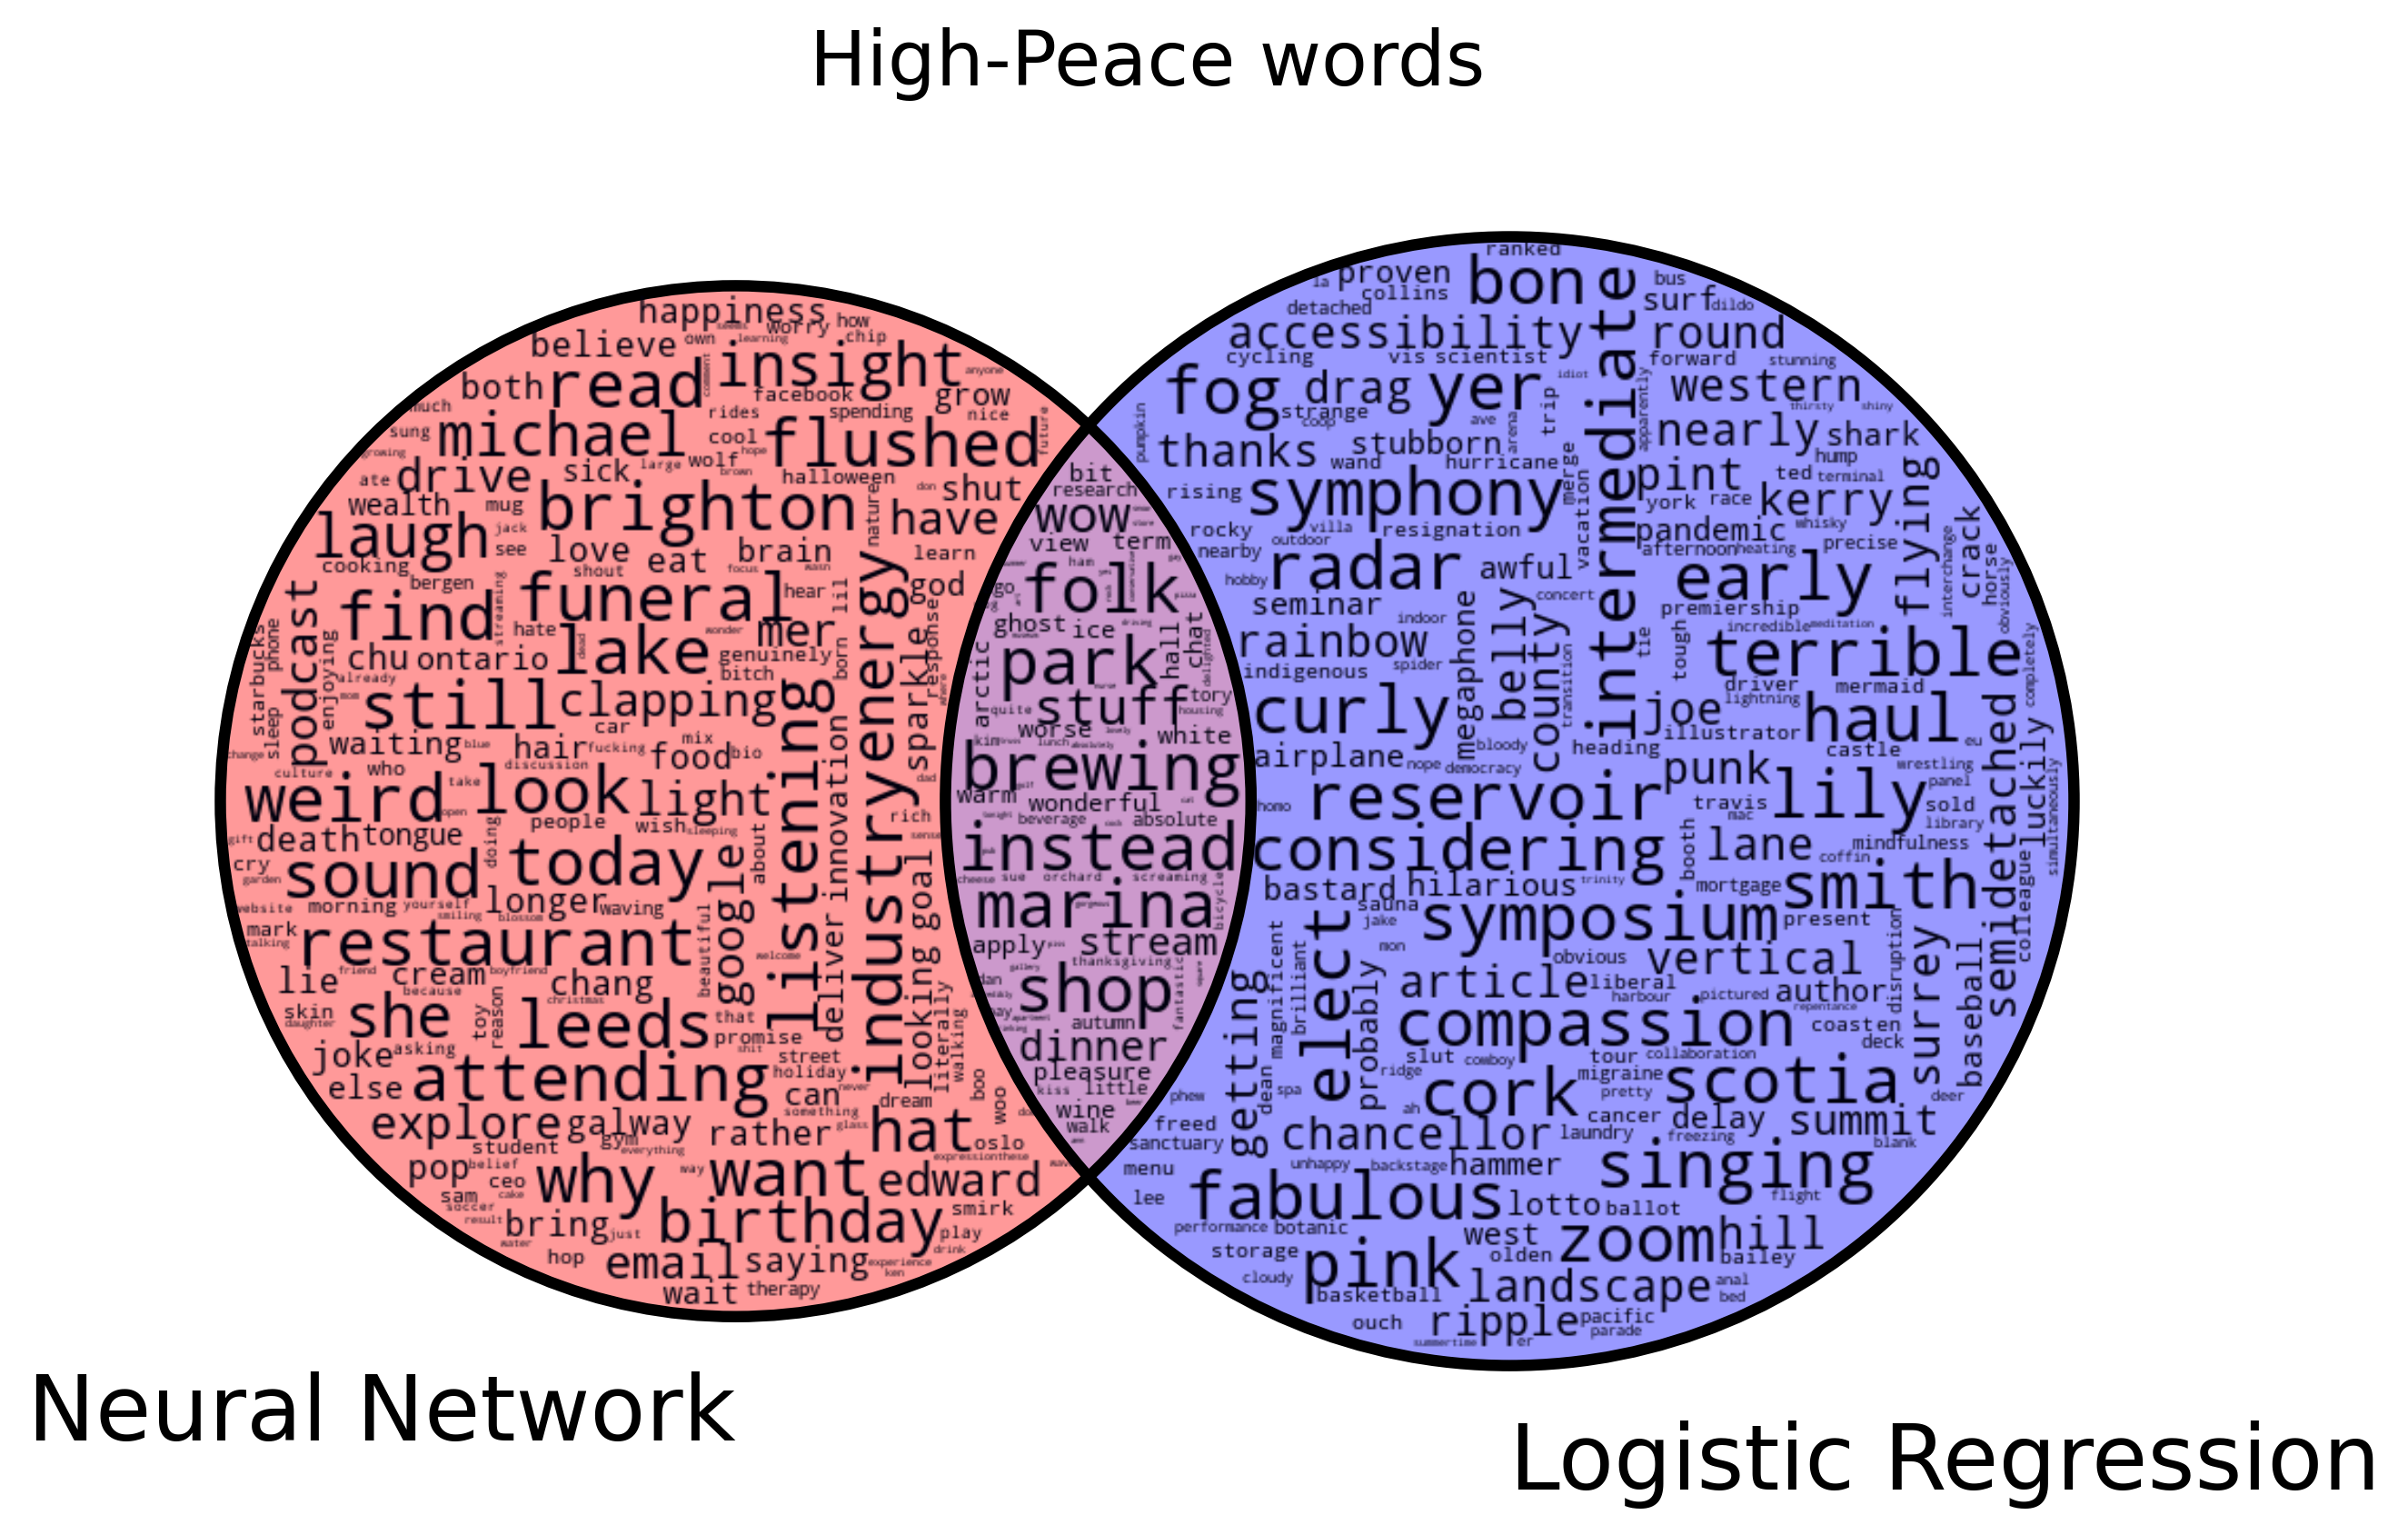

In [18]:
# https://towardsdatascience.com/venn-diagrams-and-word-clouds-in-python-1012373b38ed
import matplotlib.pyplot as plt
from matplotlib_venn_wordcloud import venn2_wordcloud
p1 = set(pos)
p2 = set(peace)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('High-Peace words', fontsize=20)

v_p = venn2_wordcloud([p1, p2], ax=ax, set_labels=['Neural Network', 'Logistic Regression'])

# add color
v_p.get_patch_by_id('10').set_color('red')
v_p.get_patch_by_id('10').set_alpha(0.4)
v_p.get_patch_by_id('01').set_color('blue')
v_p.get_patch_by_id('01').set_alpha(0.4)
v_p.get_patch_by_id('11').set_color('purple')
v_p.get_patch_by_id('11').set_alpha(0.4)

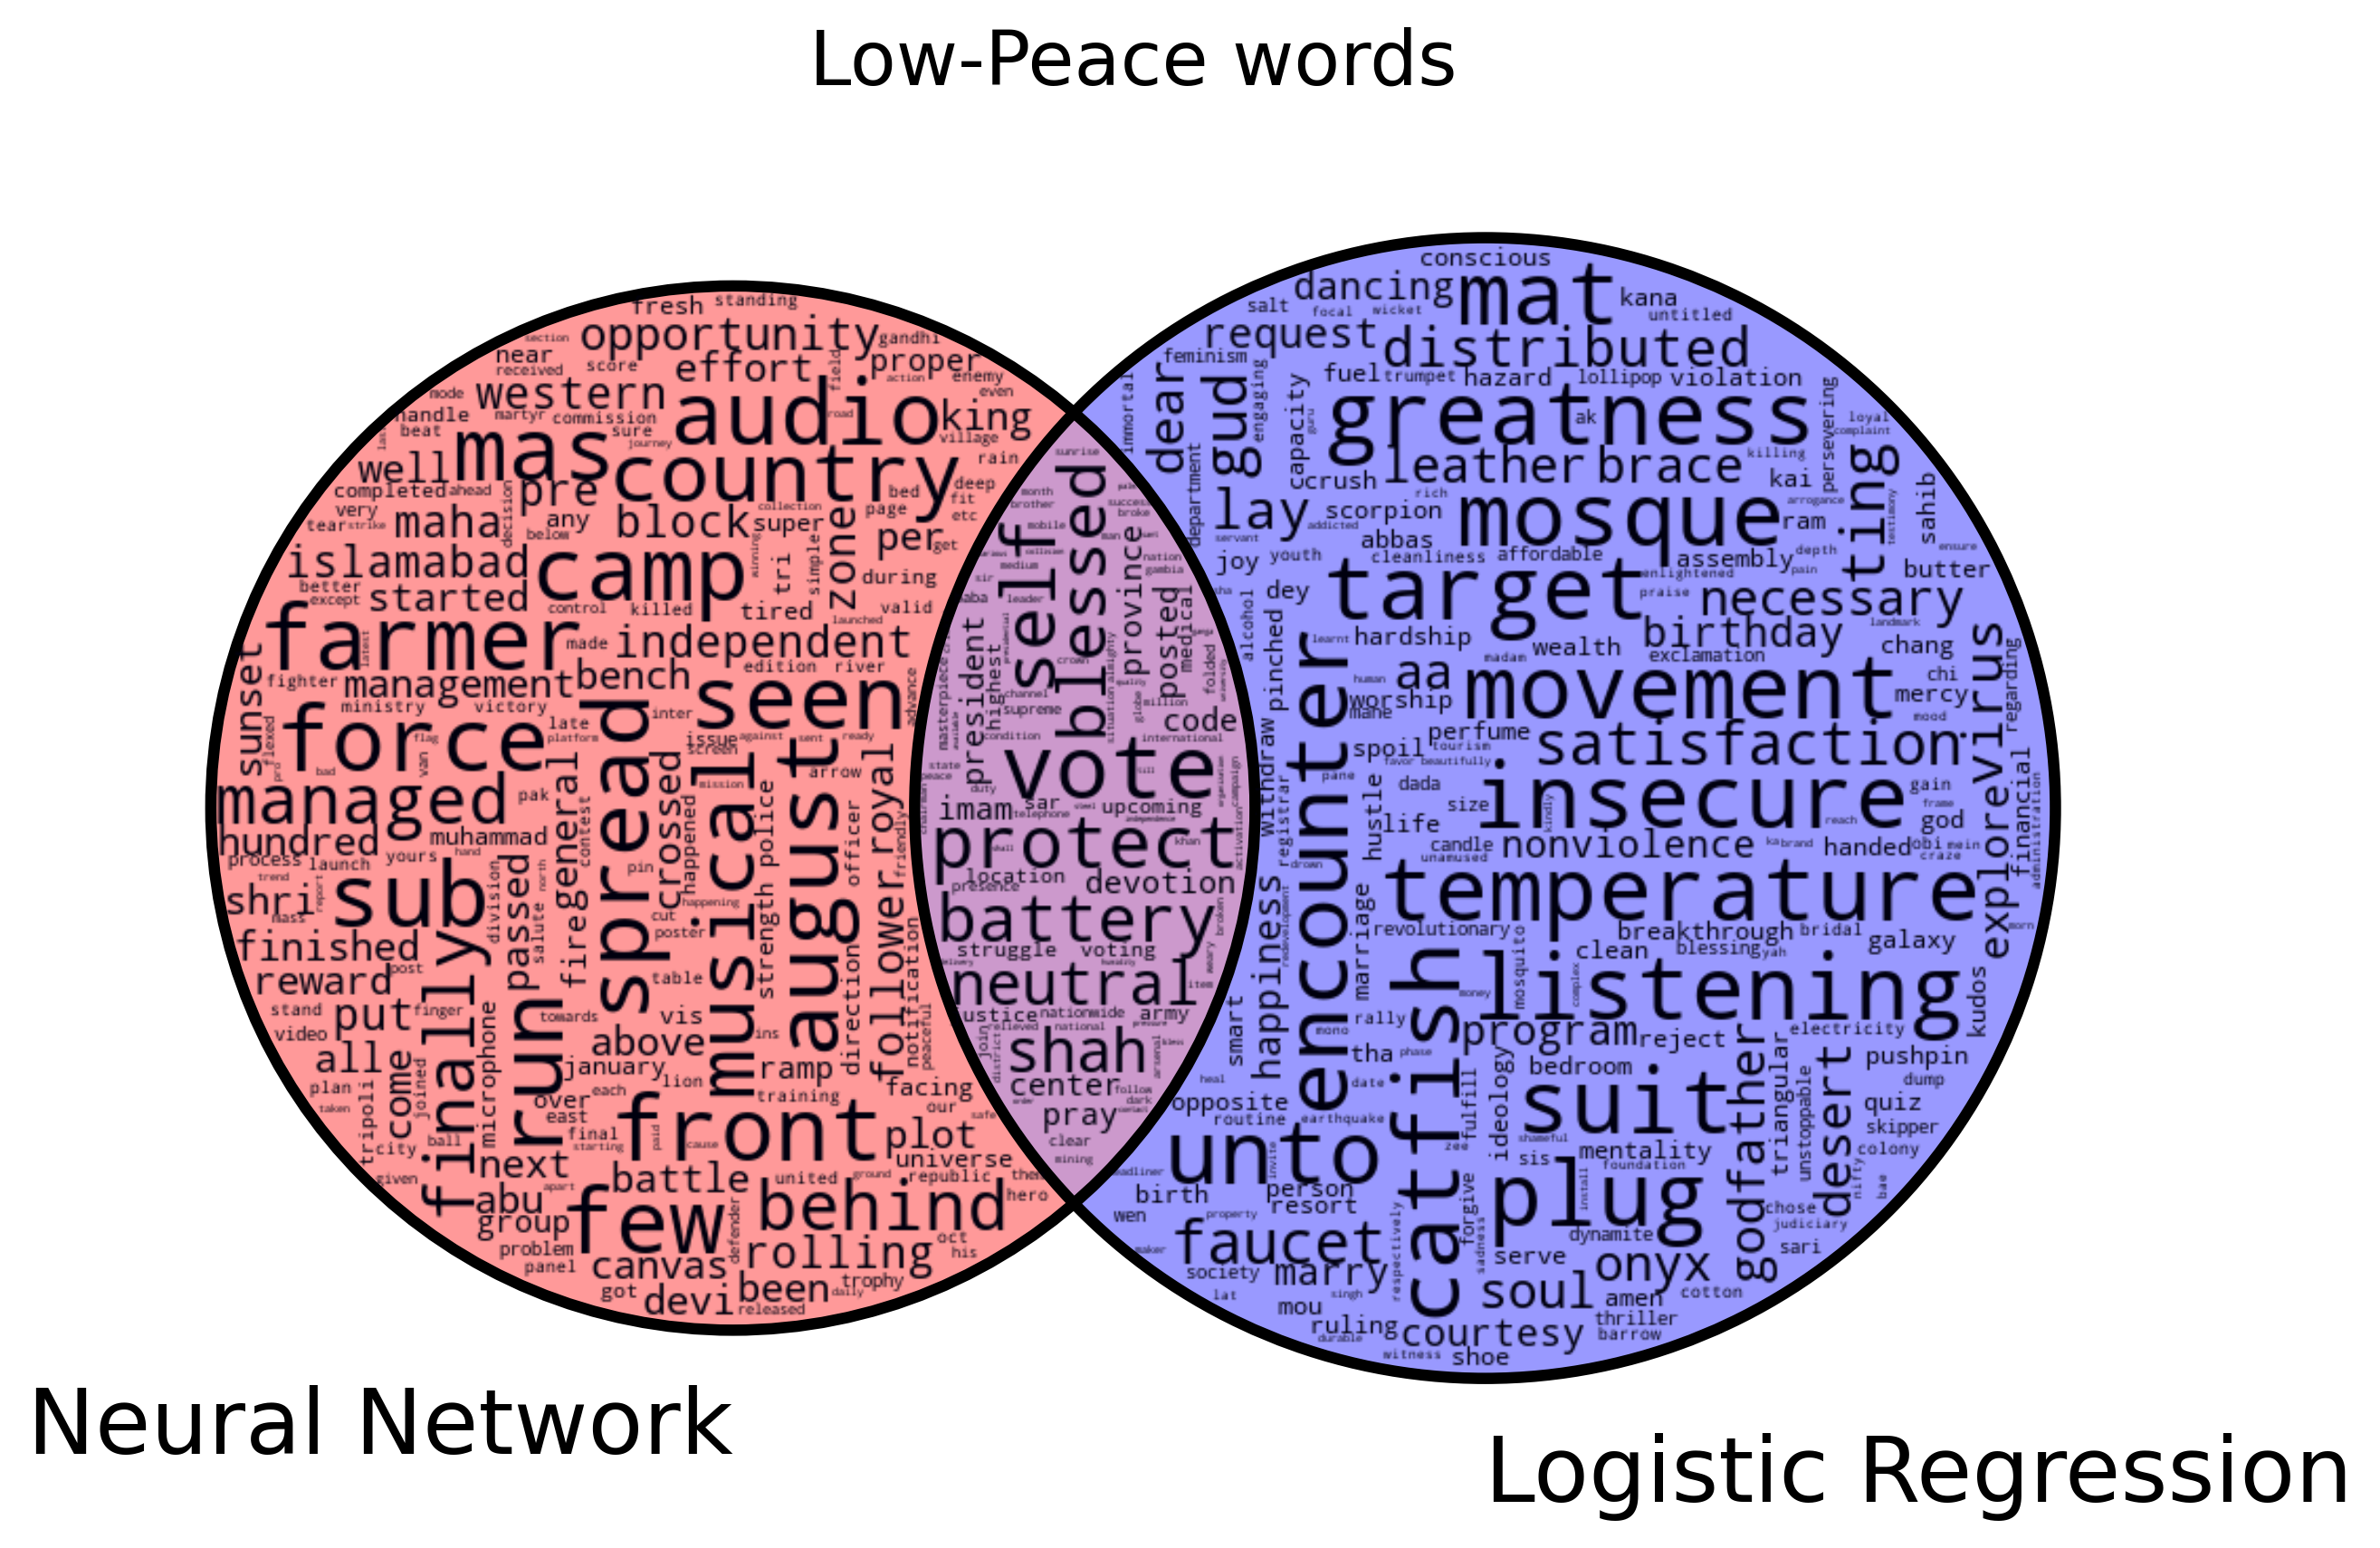

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Low-Peace words', fontsize=20)

n1 = set(neg)
n2 = set(nonpeace)

v_n = venn2_wordcloud([n1, n2], ax=ax, set_labels=['Neural Network', 'Logistic Regression']) 

v_n.get_patch_by_id('10').set_color('red')
v_n.get_patch_by_id('10').set_alpha(0.4)
v_n.get_patch_by_id('01').set_color('blue')
v_n.get_patch_by_id('01').set_alpha(0.4)
v_n.get_patch_by_id('11').set_color('purple')
v_n.get_patch_by_id('11').set_alpha(0.4)